In [1]:
import numpy as np
from copy import deepcopy

import abipy
from abipy import abilab
from abipy.dfpt.converters import phonopy_to_abinit, abinit_to_phonopy

from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections

import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pymatgen_plotly import Figure
import matplotlib.pyplot as plt


# Comparing slab and bulk phonons

In [2]:
filename_bulk = 'data/reduced_cell/02_dfpt/outdata/out_DDB'
ddb_bulk = abilab.abiopen(filename_bulk)
phonons_bulk = ddb_bulk.anaget_phonopy_ifc()

/Users/fekad/.conda/envs/surfascope/lib/python3.9/site-packages/abipy/dfpt/converters.py:95: UserWarning: The hall number obtained based on the DDB symmetries differs from the one calculated with spglib: 424 versus 523. The conversion may be incorrect. Try changing symprec.
  warnings.warn("The hall number obtained based on the DDB symmetries differs "


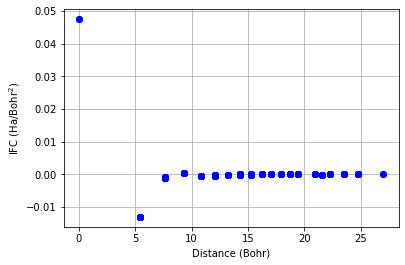

In [3]:
ifc = ddb_bulk.anaget_ifc()
fig = ifc.plot_longitudinal_ifc()

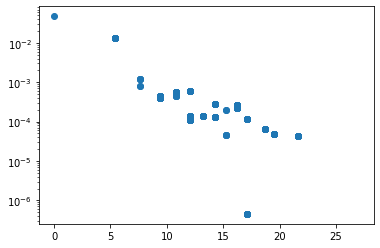

In [4]:
plt.plot(ifc.distances[0], np.abs(ifc.ifc_local_coord[:, :, 0, 0][0]), 'o')
plt.yscale('log')
plt.show()

In [5]:
filename = 'data/reduced_cell/04_fcc100_dfpt_11/outdata/out_DDB'
ddb = abilab.abiopen(filename)
phonons = ddb.anaget_phonopy_ifc()

In [8]:
scell = phonons_bulk.get_supercell()
scell.get_volume(),  np.sqrt(sum(scell._cell[0,:]**2))*np.sqrt(sum(scell._cell[1,:]**2))*np.sqrt(sum(scell._cell[2,:]**2))

(2112.8763003472277, 2112.876300347228)

In [9]:
# Length of the supercell in Borh
np.sqrt(sum(scell._cell[0,:]**2)) / 2 * 1.88973, np.sqrt(sum(scell._cell[2,:]**2))/ 2 * 1.88973

(10.80163389193711, 15.27581714556634)

In [13]:
4*3/2

6.0

In [ ]:
fig = Figure()
fig._add_unitcell(phonons_bulk.unitcell.cell)
fig._add_ball_and_stick(phonons_bulk.supercell.positions, phonons_bulk.supercell.symbols)
fig.show()

In [ ]:
fig = Figure()
fig._add_unitcell(phonons.unitcell.cell)
fig._add_ball_and_stick(phonons.supercell.positions, phonons.supercell.symbols)
# fig.fig.layout.scene.camera.projection.type = "orthographic"
fig.show()

In [ ]:
# phonons.run_mesh()
# phonons.get_mesh()
phonons_bulk.auto_band_structure()
phonons_bulk.plot_band_structure().show()

In [ ]:
phonons.auto_band_structure()
phonons.plot_band_structure().show()

In [ ]:
# 
# path = [[[0, 0, 0], [0.5, 0, 0.5], [0.625, 0.25, 0.625]],
#         [[0.375, 0.375, 0.75], [0, 0, 0], [0.5, 0.5, 0.5], [0.5, 0.25, 0.75]]]
# labels = ["$\\Gamma$", "X", "U", "K", "$\\Gamma$", "L", "W"]
# qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=51)
# 
# phonons.run_band_structure(qpoints, path_connections=connections, labels=labels)
# phonons.plot_band_structure().show()

In [ ]:
def plot_ifc_directions(phonons, atom_ind, directions):

    super_structure = phonons.get_supercell()
    force_constants = phonons.get_force_constants()[atom_ind]

    # force_constants[:,:,[0, 1, 2]] = force_constants[:,:,[2, 1, 0]]
    # force_constants[:,[0, 1, 2],:] = force_constants[:,[2, 1, 0],:]

    fig = make_subplots(
        rows=len(directions),
        cols=1,
        subplot_titles=list(
            f"Direction: {np.round(direction / np.linalg.norm(direction),3)}"
            for direction in directions
        ),
    )

    # inds = np.ravel_multi_index(np.triu_indices(4), (4, 4))
    inds = range(16)
    cols = plotly.colors.DEFAULT_PLOTLY_COLORS

    for (n, direction) in enumerate(directions):
        direction = direction / np.linalg.norm(direction)

        forces = np.dot(force_constants, direction)
        magnitude = np.linalg.norm(forces, axis=1)[:, np.newaxis]

        for (i, offset) in enumerate(inds):
            disp = (
                super_structure.positions[offset, 0:2]
                - super_structure.positions[0, 0:2]
            )

            z = super_structure.positions[offset::16, 2]
            sort_inds = np.argsort(super_structure.positions[offset::16, 2])

            fig.add_trace(
                go.Scatter(
                    x=z[sort_inds],
                    y=magnitude[offset::16, 0][sort_inds],
                    name=f"{np.round(disp,3)}",
                    line=dict(width=2, color=cols[i % 10]),
                    legendgroup=f"group{i+1}",
                    showlegend=True if (n == 0) else False,
                    visible=True if (i == 0) else'legendonly'
                ),
                row=n + 1,
                col=1,
            )

    fig.update_layout(
        height=600,
        width=800,
        legend_title_text="x-y offset:",
        title_text=f"The magnitude of interatomic force constants",
    )
    return fig

In [ ]:
# directions = [[1,-1,0], [1,1,0], [0,0,1]]
# directions = [[1,0,0], [0,1,0], [0,0,1]]
directions = phonons.unitcell.cell

# fig = plot_ifc_directions(phonons, 5, directions)
fig = plot_ifc_directions(phonons_bulk, 1, directions)
fig.show()

In [ ]:
def plot_ifc(phonons, atom_ind, direction):

    super_structure = phonons.get_supercell()
    force_constants = phonons.get_force_constants()[atom_ind]

    direction = direction / np.linalg.norm(direction)

    forces = np.dot(force_constants, direction)
    magnitude = np.linalg.norm(forces, axis=1)[:, np.newaxis]

    # inds = np.ravel_multi_index(np.triu_indices(4), (4, 4))
    inds = range(16)
    cols = plotly.colors.DEFAULT_PLOTLY_COLORS

    fig = make_subplots(rows=2, cols=1, subplot_titles=("", "Logartihmic scale"))

    for (i, offset) in enumerate(inds):
        disp = (
            super_structure.positions[offset, 0:2] - super_structure.positions[0, 0:2]
        )

        z = super_structure.positions[offset::16, 2]
        sort_inds = np.argsort(super_structure.positions[offset::16, 2])

        fig.add_trace(
            go.Scatter(
                x=z[sort_inds],
                y=magnitude[offset::16, 0][sort_inds],
                name=f"{np.round(disp,3)}",
                line=dict(width=2, color=cols[i % 10]),
                legendgroup=f"group{i+1}",
            ),
            row=1,
            col=1,
        )

        fig.add_trace(
            go.Scatter(
                x=z[sort_inds],
                y=np.log10(magnitude[offset::16, 0][sort_inds]),
                name=f"{np.round(disp,3)}",
                line=dict(width=2, color=cols[i % 10]),
                legendgroup=f"group{i+1}",
                showlegend=False,
            ),
            row=2,
            col=1,
        )

    # edit axis labels
    fig["layout"]["xaxis"]["title"] = "z"
    fig["layout"]["xaxis2"]["title"] = "z"
    fig["layout"]["yaxis"]["title"] = "abs(F)"
    fig["layout"]["yaxis2"]["title"] = "log(abs(F))"

    fig.update_layout(
        height=600,
        width=800,
        legend_title_text="x-y offset:",
        title_text=f"The magnitude of interatomic force constants along {np.round(direction,3)}",
    )
    return fig

In [ ]:
direction = np.array([1,-1,0])
# direction = np.array([1,1,0])
# direction = np.array([0,0,1])

In [ ]:
fig = plot_ifc(phonons, 5, direction)
fig.show()

In [ ]:
fig = plot_ifc(phonons_bulk, 0, direction)
fig.show()

In [ ]:

def plot_ifc_3d(phonons, atom_ind, direction, scale=1.):


    super_structure = phonons.get_supercell()
    force_constants = phonons.get_force_constants()[atom_ind]

    direction = direction / np.linalg.norm(direction)
    forces = np.dot(force_constants, direction)

    # magnitude = np.linalg.norm(forces, axis=1)[:, np.newaxis]
    # forces = forces/magnitude * np.log10(magnitude)

    x, y, z = np.transpose(super_structure.positions)
    u, v, w = np.transpose(forces)

    fig = Figure()
    fig._add_unitcell(phonons.unitcell.cell)
    fig._add_ball_and_stick(
        coords=super_structure.positions[::16], 
        species=super_structure.get_chemical_symbols()[::16]
    )

    fig.fig.add_cone(
        x=x,
        y=y,
        z=z,
        u=u,
        v=v,
        w=w,
        sizemode="absolute",
        anchor="tail",
        sizeref=scale,
    )

    return fig

In [ ]:
atom_ind = 5
# direction = np.array([1,-1,0])
# direction = np.array([1,1,0])
direction = np.array([0,0,1])

fig = plot_ifc_3d(phonons, atom_ind, direction, 1.5)
fig.show()